# AR Model

### Import Modules

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

### Ice Cream Data

In [98]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [103]:
# Read Data -
production_ice_cream = pd.read_csv('./data/ice_cream.csv', parse_dates = [0], squeeze = True, index_col = 0, date_parser = parser)

/var/folders/xc/x2qm7j8j4k75m7htc8v3w1vc0000gn/T/ipykernel_10498/3019789592.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  production_ice_cream = pd.read_csv('./data/ice_cream.csv', parse_dates = [0], squeeze = True, index_col = 0, date_parser = parser)


In [104]:
production_ice_cream.head()

DATE
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
Name: IPN31152N, dtype: float64

In [107]:
production_ice_cream.rename('production', inplace = True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [108]:
production_ice_cream.head()

DATE
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
Name: production, dtype: float64

In [109]:
# infer the frequency of the data -
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [110]:
# Just get data from 2010 onwards -
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

In [111]:
production_ice_cream

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

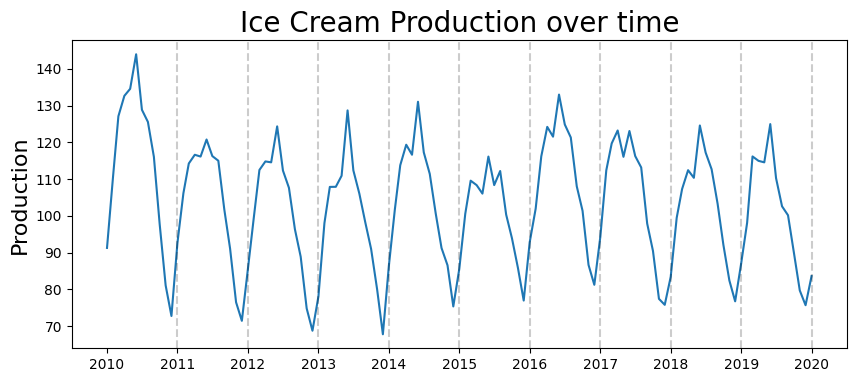

In [112]:
plt.figure(figsize = (10, 4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)

for year in range(2011, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

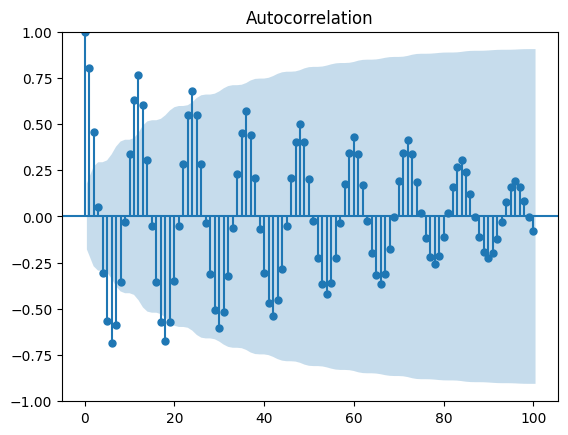

In [89]:
acf_plot = plot_acf(production_ice_cream, lags = 100)

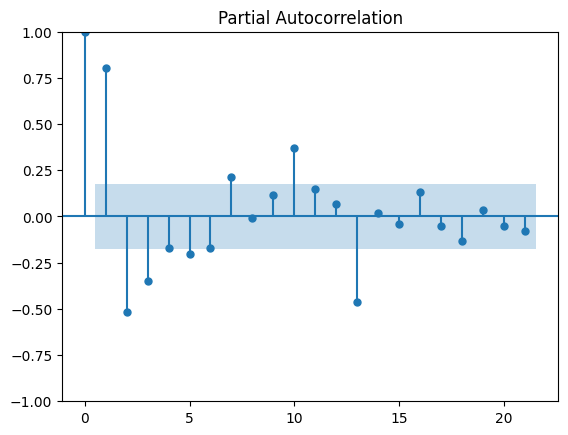

In [90]:
pacf_plot = plot_pacf(production_ice_cream)

Based on the PACF, we should start with an Auto Regressive model with lags 1, 2, 3

### AR Model

In [113]:
# Get the training and testing sets

train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days = 1):test_end]

In [114]:
train_data.tail()

DATE
2018-08-01    112.6779
2018-09-01    103.3118
2018-10-01     92.1321
2018-11-01     82.4347
2018-12-01     76.7608
Freq: MS, Name: production, dtype: float64

In [115]:
test_data.head()

DATE
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613
Freq: MS, Name: production, dtype: float64

### Fit the AR Model

In [126]:
model = ARIMA(train_data, order = (3, 0, 0)) # we start with a lag 3

In [127]:
# Fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time: ', end - start)

Model fitting time:  0.0542912483215332


In [128]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Fri, 12 May 2023   AIC                            758.170
Time:                        10:56:10   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

So, we will use an AR model with lag constant, 1 & 3 which are significant and not lag 2 which is insignificant.

In [129]:
# Get prediction start and end dates -
pred_start_date = test_data.index[0]
pred_start_date

Timestamp('2019-01-01 00:00:00', freq='MS')

In [130]:
pred_end_date = test_data.index[-1]
pred_end_date

Timestamp('2019-12-01 00:00:00', freq='MS')

In [131]:
# Get the prediction and residuals -
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data - predictions

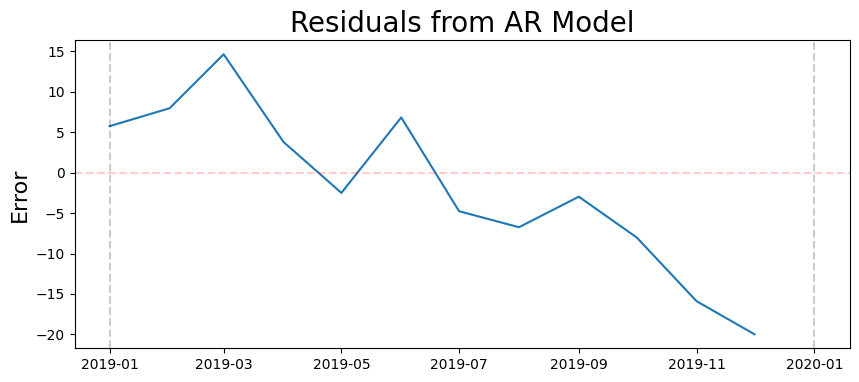

In [132]:
plt.figure(figsize = (10, 4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)

for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

Although the residuals are centered around 0 mean, but certainly there is a downward trend in the result which is not yet captured by the model.

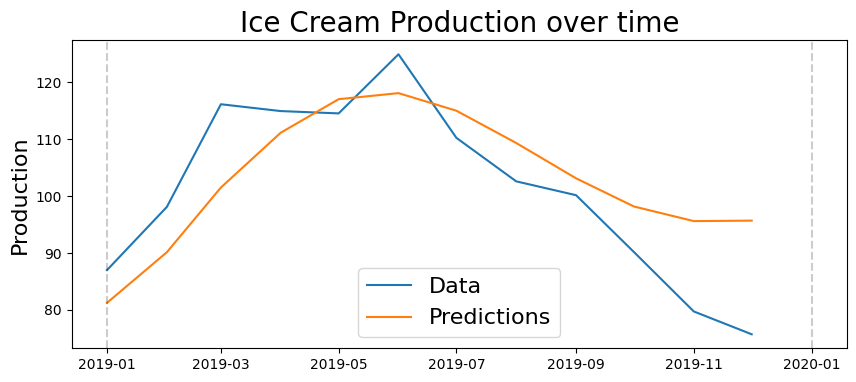

In [133]:
plt.figure(figsize = (10, 4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize = 16)
plt.title('Ice Cream Production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)

for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

In [136]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals / test_data)), 4))

# Using an AR3 model we are 9% away from the actuals

Mean Absolute Percent Error:  0.0895


In [137]:
print('Root mean squared error: ', np.sqrt(np.mean(residuals ** 2)))

# We are 10 units away from the real value

Root mean squared error:  9.884158741889435


### More AR model
Let's train it on AR7 model

In [139]:
model = ARIMA(train_data, order = (7, 0, 0)) # we use lag 3

In [140]:
# Fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time: ', end - start)

Model fitting time:  0.13924002647399902


In [141]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -361.526
Date:                Fri, 12 May 2023   AIC                            741.051
Time:                        11:38:12   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6216      1.339     77.406      0.000     100.998     106.245
ar.L1          0.9497      0.097      9.837      0.000       0.760       1.139
ar.L2         -0.0964      0.131     -0.735      0.4

In [142]:
# Get prediction start and end dates -
pred_start_date = test_data.index[0]
pred_start_date

Timestamp('2019-01-01 00:00:00', freq='MS')

In [143]:
pred_end_date = test_data.index[-1]
pred_end_date

Timestamp('2019-12-01 00:00:00', freq='MS')

In [144]:
# Get the prediction and residuals -
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data - predictions

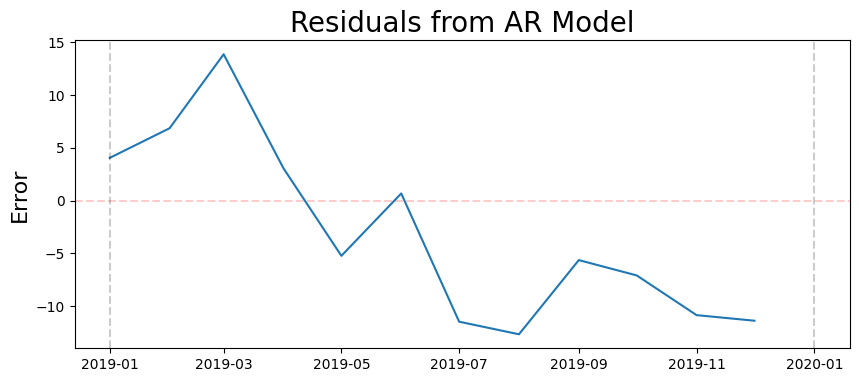

In [145]:
plt.figure(figsize = (10, 4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)

for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

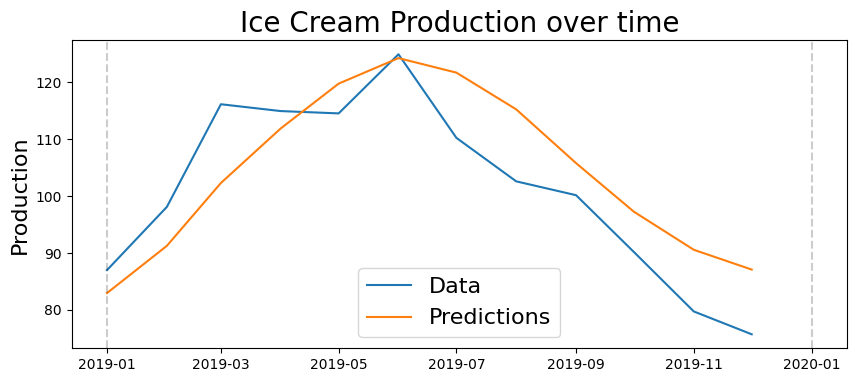

In [146]:
plt.figure(figsize = (10, 4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize = 16)
plt.title('Ice Cream Production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)

for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

In [147]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals / test_data)), 4))

# Using an AR3 model we are 8% away from the actuals

Mean Absolute Percent Error:  0.0802


In [148]:
print('Root mean squared error: ', np.sqrt(np.mean(residuals ** 2)))

# We are 8.7 units away from the real value

Root mean squared error:  8.725440378745716
